In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import rasterio
import matplotlib.pyplot as plt
from tqdm import tqdm
from shapely.geometry import Point, Polygon
import math
import pickle

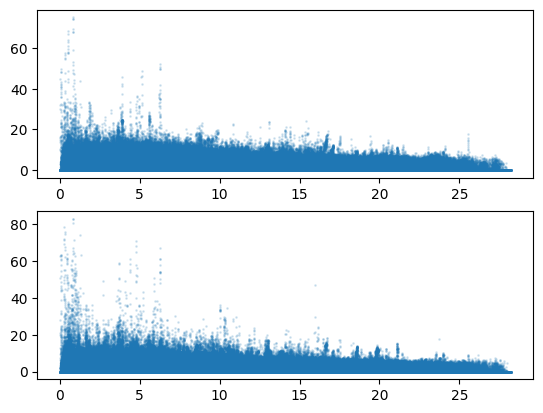

In [18]:
plt.subplot(2, 1, 1)
plt.scatter(yaou_pix_16['distance_to_center'],yaou_pix_16['building_height'],alpha=0.15, s=1)
plt.subplot(2, 1, 2)
plt.scatter(yaou_pix_23['distance_to_center'],yaou_pix_23['building_height'],alpha=0.15, s=1)

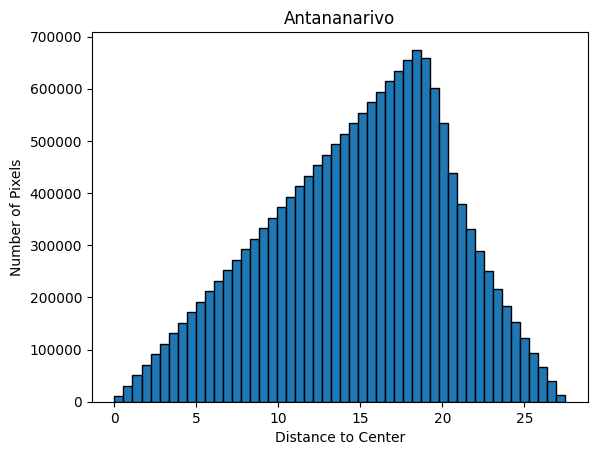

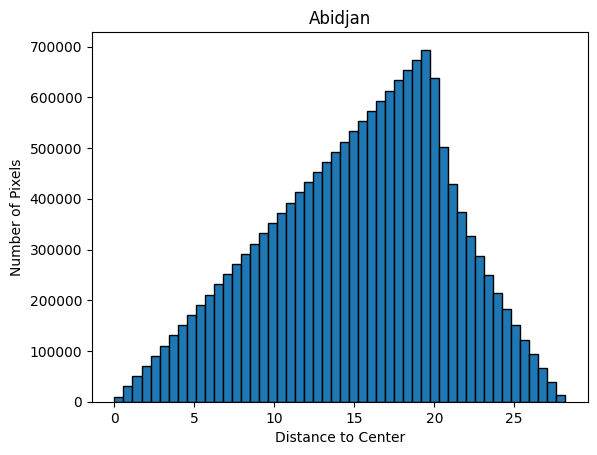

In [5]:
import matplotlib.pyplot as plt

#df_anta_1 = anta_pix_16[anta_pix_16['building_exist']==1]

# Plot histogram
plt.hist(anta_pix_16['distance_to_center'], bins=50, edgecolor='black')

# Add labels and title
plt.xlabel('Distance to Center')
plt.ylabel('Number of Pixels')
plt.title('Antananarivo')
plt.show()


plt.hist(abid_pix_16['distance_to_center'], bins=50, edgecolor='black')
# Add labels and title
plt.xlabel('Distance to Center')
plt.ylabel('Number of Pixels')
plt.title('Abidjan')
plt.show()

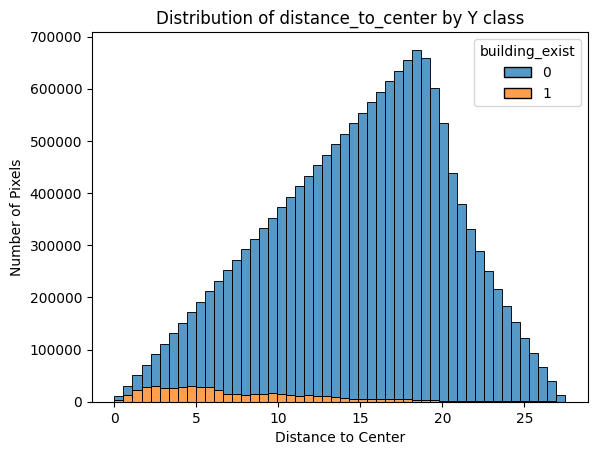

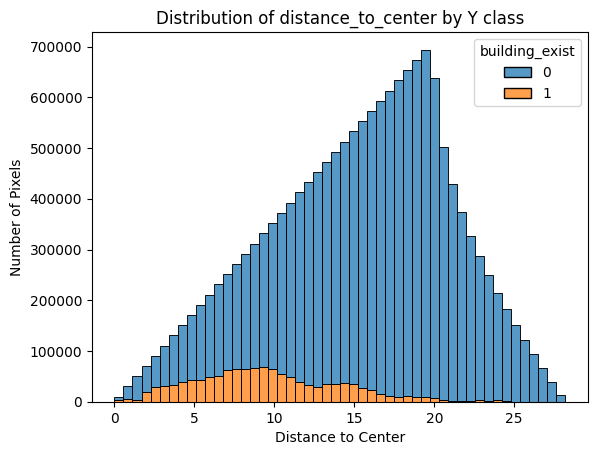

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(data=anta_pix_16, x='distance_to_center', hue='building_exist', bins=50, stat='count', multiple='stack')
plt.title("Distribution of distance_to_center by Y class")
plt.xlabel("Distance to Center")
plt.ylabel("Number of Pixels")
plt.show()


sns.histplot(data=abid_pix_16, x='distance_to_center', hue='building_exist', bins=50, stat='count', multiple='stack')
plt.title("Distribution of distance_to_center by Y class")
plt.xlabel("Distance to Center")
plt.ylabel("Number of Pixels")
plt.show()

Optimization terminated successfully.
         Current function value: 0.113526
         Iterations 9
                           Logit Regression Results                           
Dep. Variable:         building_exist   No. Observations:             16008001
Model:                          Logit   Df Residuals:                 16007999
Method:                           MLE   Df Model:                            1
Date:                Fri, 25 Apr 2025   Pseudo R-squ.:                  0.2088
Time:                        13:55:32   Log-Likelihood:            -1.8173e+06
converged:                       True   LL-Null:                   -2.2968e+06
Covariance Type:            nonrobust   LLR p-value:                     0.000
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
intercept             -0.3958      0.003   -134.233      0.000      -0.402      -0.390
dista

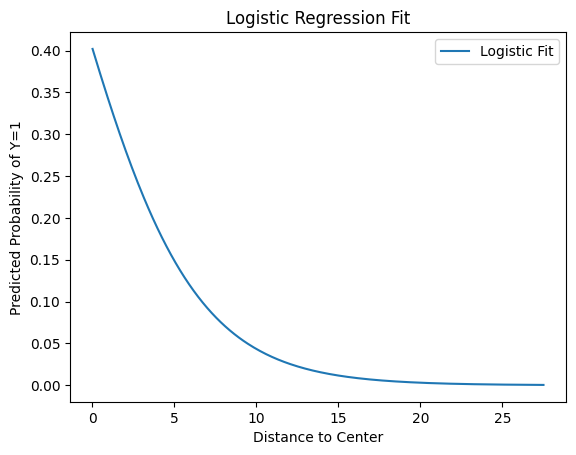

In [7]:
import statsmodels.api as sm
import numpy as np

df = anta_pix_16
df['intercept'] = 1
logit = sm.Logit(df['building_exist'], df[['intercept', 'distance_to_center']])
result = logit.fit()
print(result.summary())

# Predict probabilities
distance_vals = np.linspace(df['distance_to_center'].min(), df['distance_to_center'].max(), 300)
X_pred = sm.add_constant(distance_vals)
y_pred = result.predict(X_pred)

plt.plot(distance_vals, y_pred, label="Logistic Fit")
plt.xlabel("Distance to Center")
plt.ylabel("Predicted Probability of Y=1")
plt.title("Logistic Regression Fit")
plt.legend()
plt.show()

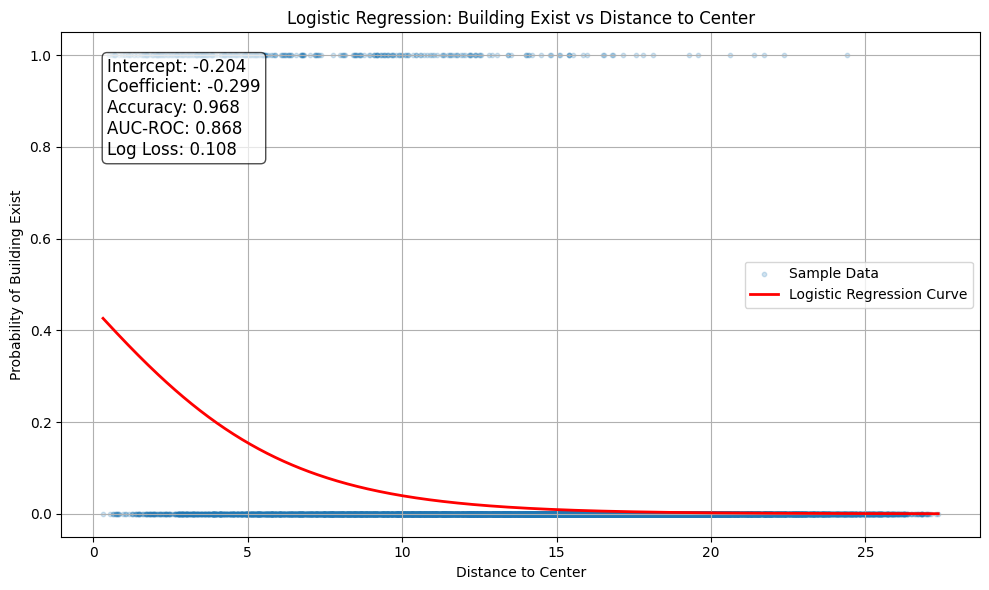

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss

# Optional: sample to keep the plot clean and fast
sample_df = anta_pix_16.sample(n=10000, random_state=72)

# Prepare data
X_sample = sample_df[['distance_to_center']]
y_sample = sample_df['building_exist']

# Fit the logistic regression model
model = LogisticRegression()
model.fit(X_sample, y_sample)

# Predictions for evaluation
y_pred = model.predict(X_sample)
y_pred_proba = model.predict_proba(X_sample)[:, 1]

# Evaluation metrics
accuracy = accuracy_score(y_sample, y_pred)
auc = roc_auc_score(y_sample, y_pred_proba)
logloss = log_loss(y_sample, y_pred_proba)

# Create a range of distance values for the smooth curve
x_vals = np.linspace(X_sample['distance_to_center'].min(), X_sample['distance_to_center'].max(), 500)
x_vals_df = pd.DataFrame(x_vals, columns=['distance_to_center'])

# Predict probabilities
y_probs = model.predict_proba(x_vals_df)[:, 1]

# Plot
plt.figure(figsize=(10, 6))
plt.scatter(X_sample['distance_to_center'], y_sample, alpha=0.2, label='Sample Data', s=10)
plt.plot(x_vals, y_probs, color='red', linewidth=2, label='Logistic Regression Curve')
plt.xlabel('Distance to Center')
plt.ylabel('Probability of Building Exist')
plt.title('Logistic Regression: Building Exist vs Distance to Center')
plt.legend()
plt.grid(True)

# Annotate with metrics
intercept = model.intercept_[0]
coef = model.coef_[0][0]

textstr = '\n'.join((
    f'Intercept: {intercept:.3f}',
    f'Coefficient: {coef:.3f}',
    f'Accuracy: {accuracy:.3f}',
    f'AUC-ROC: {auc:.3f}',
    f'Log Loss: {logloss:.3f}'
))

plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes,
         fontsize=12, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

plt.tight_layout()
plt.show()

In [15]:
def load_alpha_shape(city_name, year, input_dir="alpha_shapes"):
    """Load alpha shape from a pickle file with city and year information"""
    filename = os.path.join(input_dir, f"{city_name}_{year}_alpha_shape.pkl")
    print(f"[DEBUG] Attempting to load alpha shape from {filename}")
    
    try:
        if os.path.exists(filename):
            with open(filename, 'rb') as f:
                alpha_shape = pickle.load(f)
            print("[DEBUG] Alpha shape loaded successfully")
            return alpha_shape
        else:
            print("[WARNING] Alpha shape file not found")
            return None
    except Exception as e:
        print(f"[ERROR] Failed to load alpha shape: {e}")
        return None

cities = [
    ("Antananarivo", 2016),
    ("Antananarivo", 2023),
    ("Abidjan", 2016),
    ("Abidjan", 2023)
]
colors = ['#88D498', '#1A936F', '#64B2CD', '#3C70A4']

os.makedirs("visualizations", exist_ok=True)

for i, (city, year) in enumerate(cities):
    
    alpha_hull = load_alpha_shape(city, year)
    
    try:

        gdf_hull = gpd.GeoDataFrame(geometry=[alpha_hull])
        minx, miny, maxx, maxy = alpha_hull.bounds
        center_lat = (miny + maxy) / 2
        center_lon = (minx + maxx) / 2
        
        plt.figure(figsize=(12, 10))
        gdf_hull.plot(alpha=0.5, edgecolor='black', color=colors[i])
        plt.title(f'{city} {year} Building Alpha Hull')
        plt.xlabel('Longitude')
        plt.ylabel('Latitude')
        plt.ylim(center_lat - 0.2, center_lat + 0.2)  # 0.4° total range
        plt.xlim(center_lon - 0.2, center_lon + 0.2)
        hull_output_file = os.path.join("visualizations", f"{city}_{year}_alpha_hull.png")
        plt.savefig(hull_output_file)
        print(f"[SUCCESS] Plot saved: {hull_output_file}")
        plt.close()
        
    except Exception as e:
        print(f"Error plotting {city} {year}: {e}")

[DEBUG] Attempting to load alpha shape from alpha_shapes/Antananarivo_2016_alpha_shape.pkl
[DEBUG] Alpha shape loaded successfully
[SUCCESS] Plot saved: visualizations/Antananarivo_2016_alpha_hull.png
[DEBUG] Attempting to load alpha shape from alpha_shapes/Antananarivo_2023_alpha_shape.pkl
[DEBUG] Alpha shape loaded successfully
[SUCCESS] Plot saved: visualizations/Antananarivo_2023_alpha_hull.png
[DEBUG] Attempting to load alpha shape from alpha_shapes/Abidjan_2016_alpha_shape.pkl
[DEBUG] Alpha shape loaded successfully
[SUCCESS] Plot saved: visualizations/Abidjan_2016_alpha_hull.png
[DEBUG] Attempting to load alpha shape from alpha_shapes/Abidjan_2023_alpha_shape.pkl
[DEBUG] Alpha shape loaded successfully
[SUCCESS] Plot saved: visualizations/Abidjan_2023_alpha_hull.png


<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

<Figure size 1200x1000 with 0 Axes>

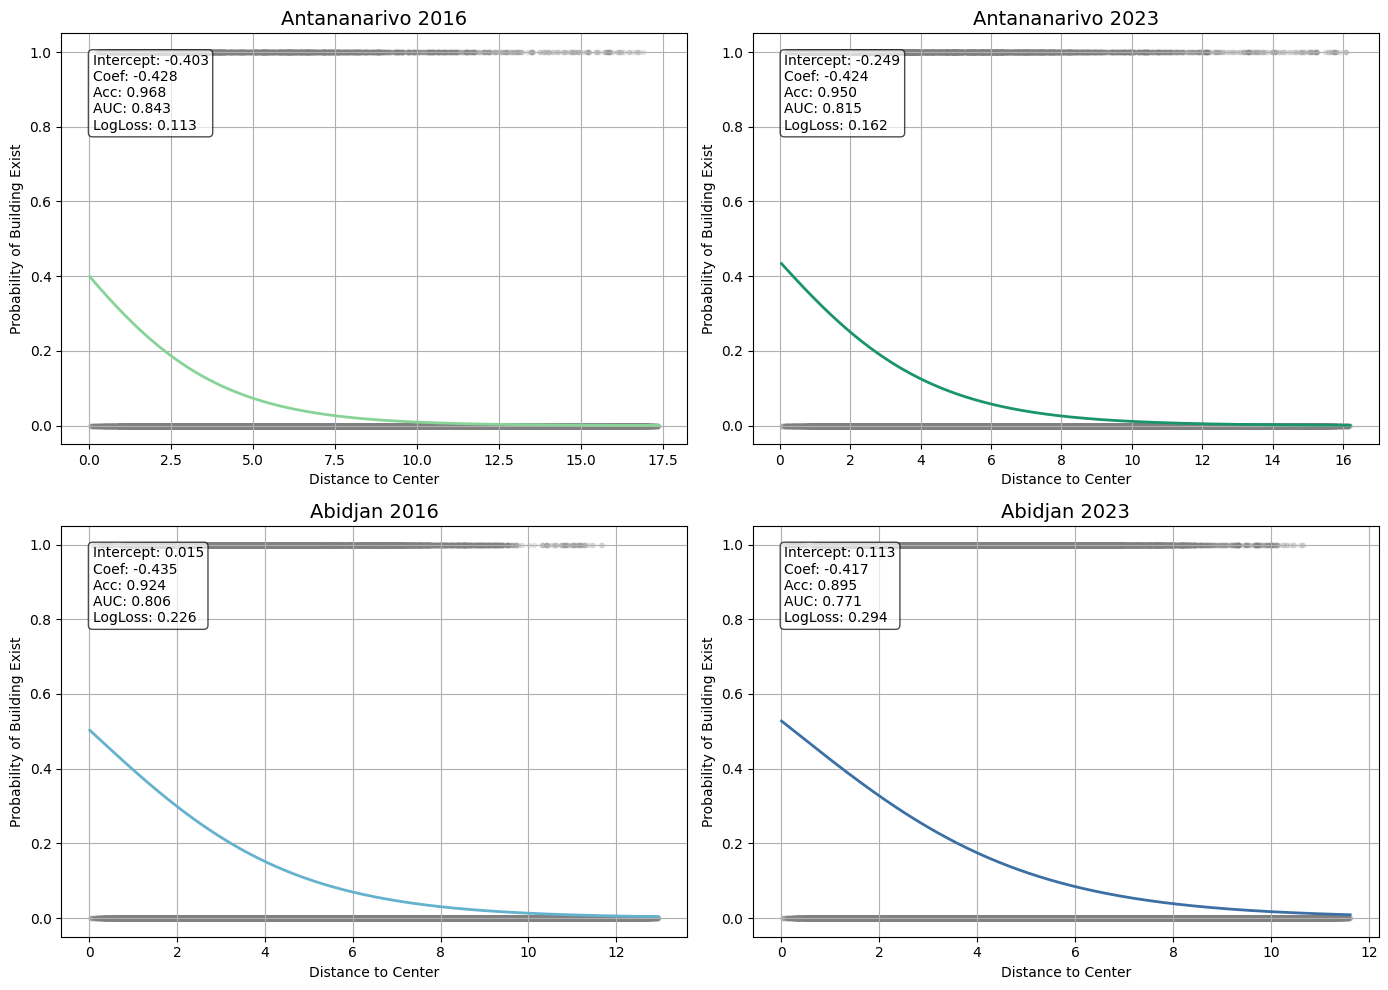

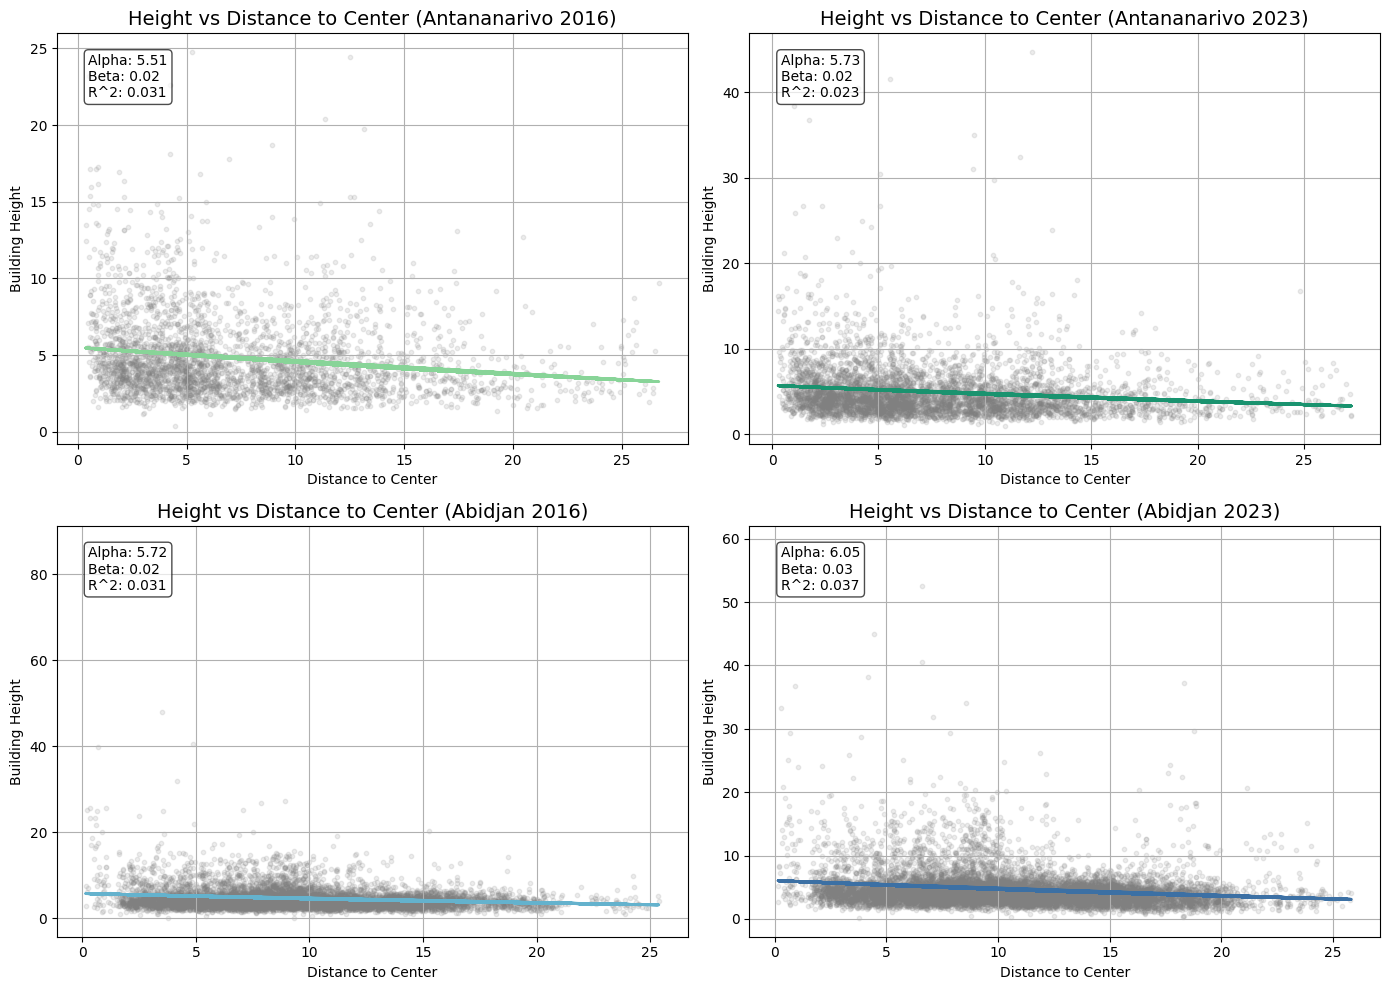

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss
from sklearn.metrics import r2_score

# Dataset paths
datasets = {
    "Antananarivo 2016": "pixel_data/Antananarivo_2016_all_pixels_data.csv",
    "Antananarivo 2023": "pixel_data/Antananarivo_2023_all_pixels_data.csv",
    "Abidjan 2016": "pixel_data/Abidjan_2016_all_pixels_data.csv",
    "Abidjan 2023": "pixel_data/Abidjan_2023_all_pixels_data.csv"
}

# Distinct colors for each dataset
colors = ['#88D498', '#1A936F', '#64B2CD', '#3C70A4']

population = [2500317,2863971,4717347,5877152]

# Containers for reused data
sampled_data = []

# ---------- Plot 1: Logistic regression plots ----------
fig1, axes1 = plt.subplots(2, 2, figsize=(14, 10))
axes1 = axes1.flatten()

for i, (title, path) in enumerate(datasets.items()):
    # Load and sample data
    df = pd.read_csv(path).sample(n=100000, random_state=72)
    sampled_data.append((title, df))  # store for second plot

    X = df[['distance_to_center']]/ math.sqrt(population[i]) *1000
    y = df['building_exist']

    # Logistic Regression
    model = LogisticRegression()
    model.fit(X, y)

    # Predict and evaluate
    y_pred = model.predict(X)
    y_proba = model.predict_proba(X)[:, 1]

    intercept = model.intercept_[0]
    coef = model.coef_[0][0]
    accuracy = accuracy_score(y, y_pred)
    auc = roc_auc_score(y, y_proba)
    logloss = log_loss(y, y_proba)

    # Smooth curve
    x_vals = np.linspace(X['distance_to_center'].min(), X['distance_to_center'].max(), 500)
    x_df = pd.DataFrame(x_vals, columns=['distance_to_center'])
    y_curve = model.predict_proba(x_df)[:, 1]

    # Plot
    ax = axes1[i]
    ax.scatter(X['distance_to_center'], y, color="grey", alpha=0.15, s=10, label='Data')
    ax.plot(x_vals, y_curve, color=colors[i], linewidth=2, label='Logistic Curve')
    ax.set_title(title, fontsize=14)
    ax.set_xlabel("Distance to Center")
    ax.set_ylabel("Probability of Building Exist")
    ax.grid(True)

    # Metrics annotation
    textstr = '\n'.join((
        f'Intercept: {intercept:.3f}',
        f'Coef: {coef:.3f}',
        f'Acc: {accuracy:.3f}',
        f'AUC: {auc:.3f}',
        f'LogLoss: {logloss:.3f}'
    ))
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes,
            fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

plt.tight_layout()
#plt.savefig('visualizations/area_vs_dist(logistics).png')
plt.show()

# # ---------- Plot 2: Latitude/Longitude maps ----------
# fig2, axes2 = plt.subplots(2, 2, figsize=(14, 10))
# axes2 = axes2.flatten()

# for i, (title, df) in enumerate(sampled_data):
#     ax = axes2[i]
#     ax.scatter(df['longitude'], df['latitude'], c=colors[i], s=2, alpha=0.5)
#     ax.set_title(f"{title} - Spatial Distribution", fontsize=14)
#     ax.set_xlabel("Longitude")
#     ax.set_ylabel("Latitude")
#     ax.set_ylim((np.mean(df['latitude']-0.2)), (np.mean(df['latitude']+0.2)))
#     ax.grid(True)
#     ax.set_aspect('equal', adjustable='box')

# plt.tight_layout()
# #plt.savefig('visualizations/spatial_distribution.png')
# plt.show()

# ---------- Plot 3: Exponential Curve Fitting without Sorting ----------
from scipy.optimize import curve_fit

# Function for the exponential curve
def exp_func(x, alpha, beta):
    return alpha * np.exp(-beta * x)
    
fig3, axes3 = plt.subplots(2, 2, figsize=(14, 10))
axes3 = axes3.flatten()

for i, (title, df) in enumerate(sampled_data):
    # Filter out where building_exist = 0, keep building_exist = 1
    df_filtered = df[df['building_exist'] == 1]
    
    # X and Y values
    X = df_filtered['distance_to_center']
    Y = df_filtered['building_height']

    # Fit the exponential curve to the data
    popt, _ = curve_fit(exp_func, X, Y, p0=(1, 0.1))  # Initial guess for alpha and beta

    # Get fitted values
    alpha, beta = popt
    Y_fitted = exp_func(X, *popt)

    # Calculate R^2
    r2 = r2_score(Y, Y_fitted)

    # Plotting
    ax = axes3[i]
    ax.scatter(X, Y, color="grey", alpha=0.15, s=10, label='Data')
    ax.plot(X, Y_fitted, color=colors[i], linewidth=2, label=f'Exponential Fit: Y = {alpha:.2f} * e^(-{beta:.2f} * X)')
    ax.set_title(f"Height vs Distance to Center ({title})", fontsize=14)
    ax.set_xlabel("Distance to Center")
    ax.set_ylabel("Building Height")
    ax.grid(True)

    # Display alpha, beta, and R^2 in the plot
    textstr = '\n'.join((
        f'Alpha: {alpha:.2f}',
        f'Beta: {beta:.2f}',
        f'R^2: {r2:.3f}'
    ))
    ax.text(0.05, 0.95, textstr, transform=ax.transAxes,
            fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

plt.tight_layout()
#plt.savefig('visualizations/height_vs_dist(exponential).png')
plt.show()

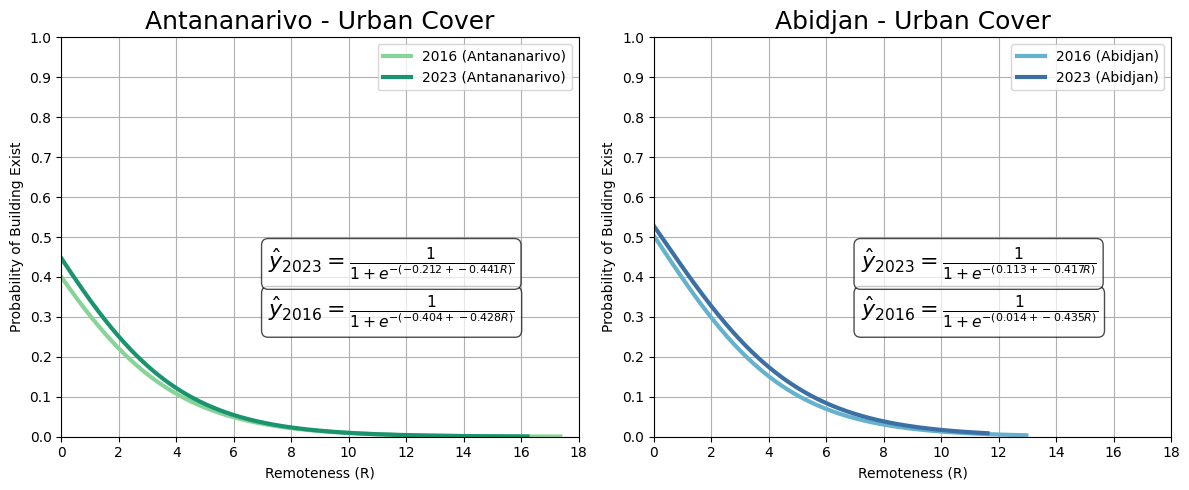

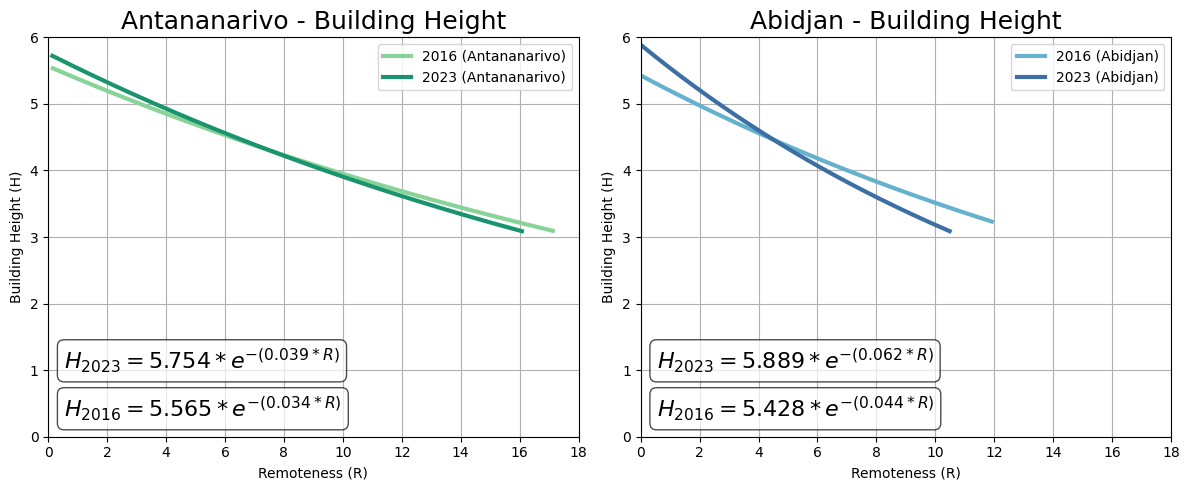

In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.optimize import curve_fit
import math
import matplotlib.ticker as ticker

# 数据集路径
datasets = {
    "Antananarivo 2016": "pixel_data/Antananarivo_2016_all_pixels_data.csv",
    "Antananarivo 2023": "pixel_data/Antananarivo_2023_all_pixels_data.csv",
    "Abidjan 2016": "pixel_data/Abidjan_2016_all_pixels_data.csv",
    "Abidjan 2023": "pixel_data/Abidjan_2023_all_pixels_data.csv"
}

colors = ['#88D498', '#1A936F', '#64B2CD', '#3C70A4']
city_pairs = [("Antananarivo 2016", "Antananarivo 2023"), 
              ("Abidjan 2016", "Abidjan 2023")]
populations = [(2500317, 2863971), (4717347, 5877152)]

# 逻辑回归函数
def get_logit_ci(X, y):
    X_const = sm.add_constant(X)
    model = sm.Logit(y, X_const).fit(disp=False)
    conf = model.conf_int(alpha=0.05)
    conf.columns = ['2.5%', '97.5%']
    return model, model.params, conf

# 指数回归函数
def exp_func(x, alpha, beta):
    return alpha * np.exp(-beta * x)

def get_exp_ci(X, Y):
    popt, pcov = curve_fit(exp_func, X, Y, p0=(1, 0.1))
    perr = np.sqrt(np.diag(pcov))
    alpha, beta = popt
    alpha_ci = (alpha - 1.96 * perr[0], alpha + 1.96 * perr[0])
    beta_ci = (beta - 1.96 * perr[1], beta + 1.96 * perr[1])
    return popt, alpha_ci, beta_ci, perr

# ===== 图1：Logistic 回归 =====
fig_logit, axes_logit = plt.subplots(1, 2, figsize=(12, 5))
logit_results = []
max_remoteness_vals = []
max_p_vals = []

for i, (label1, label2) in enumerate(city_pairs):
    ax = axes_logit[i]
    for j, label in enumerate([label1, label2]):
        year = label.split()[-1]
        city = label.split()[0]
        df = pd.read_csv(datasets[label]).sample(n=100000, random_state=72)

        remoteness = df[['distance_to_center']] / math.sqrt(populations[i][j]) * 1000
        X = remoteness.rename(columns={'distance_to_center': 'remoteness_to_center'})
        y = df['building_exist']

        model, params, conf = get_logit_ci(X, y)
        y_pred = model.predict(sm.add_constant(X))

        intercept, coef = params['const'], params['remoteness_to_center']
        intercept_ci_low, intercept_ci_high = conf.loc['const']
        coef_ci_low, coef_ci_high = conf.loc['remoteness_to_center']
        mcfadden_r2 = 1 - model.llf / model.llnull
        r2_traditional = 1 - np.sum((y - y_pred) ** 2) / np.sum((y - np.mean(y)) ** 2)

        logit_results.append({
            "City": city,
            "Year": year,
            "kappa": round(intercept, 3),
            "95% CI kappa": f"[{intercept_ci_low:.3f}, {intercept_ci_high:.3f}]",
            "delta": round(coef, 3),
            "95% CI delta": f"[{coef_ci_low:.3f}, {coef_ci_high:.3f}]",
            "McFadden R2": round(mcfadden_r2, 4),
            "Traditional R2": round(r2_traditional, 4)
        })

        max_remoteness_vals.append(X['remoteness_to_center'].max())
        max_p_vals.append(y.max())
        x_vals = np.linspace(X['remoteness_to_center'].min(), X['remoteness_to_center'].max(), 500)
        y_vals = model.predict(sm.add_constant(pd.DataFrame({'remoteness_to_center': x_vals})))

        ax.plot(x_vals, y_vals, color=colors[j + i*2], linewidth=3, label=f"{year} ({city})")
        equation_text = (
            r"$\hat{y}_{" + f"{year}" + r"} = \frac{{1}}{{1 + e^{{-(" +
            f"{intercept:.3f} + {coef:.3f}R" +
            r")}}}}$"
        )
        ax.text(0.4, 0.3 + j*0.12, equation_text, transform=ax.transAxes,
                fontsize=16, bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

    ax.set_title(f"{label1.split()[0]} - Urban Cover", fontsize=18)
    ax.set_xlabel("Remoteness (R)")
    ax.set_ylabel("Probability of Building Exist")
    ax.legend()
    ax.grid(True)

xlim_max = math.ceil(max(max_remoteness_vals))
ylim_max = math.ceil(max(max_p_vals))
for ax in axes_logit:
    ax.set_xlim(0, xlim_max)
    ax.set_ylim(0, ylim_max)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))

plt.tight_layout()
plt.savefig('visualizations/logistic_comparison.png')
plt.show()

pd.DataFrame(logit_results).to_csv("area_remoteness_params.csv", index=False)

# ===== 图2：Exponential 回归 =====
fig_exp, axes_exp = plt.subplots(1, 2, figsize=(12, 5))
exp_results = []
max_remoteness_vals = []

for i, (label1, label2) in enumerate(city_pairs):
    ax = axes_exp[i]
    for j, label in enumerate([label1, label2]):
        year = label.split()[-1]
        city = label.split()[0]
        population = populations[i][j]

        df = pd.read_csv(datasets[label])
        df_filter = df[df['building_exist'] == 1]
        df_sample = df_filter.sample(n=10000, random_state=72)

        remoteness = df_sample['distance_to_center'] / math.sqrt(population) * 1000
        height = df_sample['building_height']

        popt, alpha_ci, beta_ci, _ = get_exp_ci(remoteness.values, height.values)
        alpha, beta = popt
        y_pred = exp_func(remoteness.values, *popt)
        ss_res = np.sum((height.values - y_pred) ** 2)
        ss_tot = np.sum((height.values - np.mean(height.values)) ** 2)
        r2_traditional = 1 - ss_res / ss_tot
        alpha_ci_low, alpha_ci_high = alpha_ci
        beta_ci_low, beta_ci_high = beta_ci

        exp_results.append({
            "City": city,
            "Year": year,
            "alpha": round(alpha, 3),
            "95% CI alpha": f"[{alpha_ci_low:.3f}, {alpha_ci_high:.3f}]",
            "beta": round(beta, 3),
            "95% CI beta": f"[{beta_ci_low:.3f}, {beta_ci_high:.3f}]",
            "Traditional R2": round(r2_traditional, 4)
        })
        
        max_remoteness_vals.append(remoteness.max())
        x_vals = np.linspace(remoteness.min(), remoteness.max(), 500)
        y_vals = exp_func(x_vals, *popt)

        ax.plot(x_vals, y_vals, color=colors[j + i*2], linewidth=3, label=f"{year} ({city})")
        equation_text = (
            r"${H}_{" + f"{year}" + r"} = " + f"{alpha:.3f}" + r" * e^{-(" + f"{beta:.3f}" + r" * R)}$"
        )
        ax.text(0.03, 0.05 + j*0.12, equation_text, transform=ax.transAxes,
                fontsize=16, bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

    ax.set_title(f"{label1.split()[0]} - Building Height", fontsize=18)
    ax.set_xlabel("Remoteness (R)")
    ax.set_ylabel("Building Height (H)")
    ax.legend()
    ax.grid(True)
    
xlim_max = math.ceil(max(max_remoteness_vals))
for ax in axes_exp:
    ax.set_xlim(0, xlim_max)
    ax.set_ylim(0, 6)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

plt.tight_layout()
plt.savefig('visualizations/exponential_comparison.png')
plt.show()

pd.DataFrame(exp_results).to_csv("height_remoteness_params.csv", index=False)

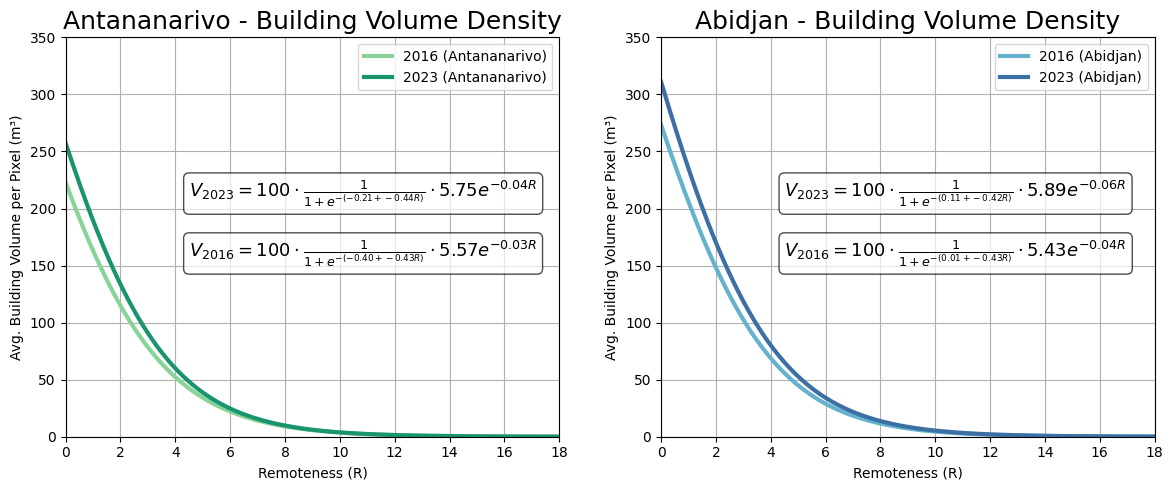

In [27]:
fig_vol, axes_vol = plt.subplots(1, 2, figsize=(12, 5))
pixel_area = 100

for i, (label1, label2) in enumerate(city_pairs):
    ax = axes_vol[i]
    for j, label in enumerate([label1, label2]):
        city = label.split()[0]
        year = label.split()[1]
        
        logit_row = next(r for r in logit_results if r['City'] == city and r['Year'] == year)
        exp_row = next(r for r in exp_results if r['City'] == city and r['Year'] == year)

        kappa = logit_row['kappa']
        delta = logit_row['delta']
        alpha = exp_row['alpha']
        beta = exp_row['beta']

        x_vals = np.linspace(0, xlim_max, 500)
        prob = 1 / (1 + np.exp(-(kappa + delta * x_vals)))
        height = alpha * np.exp(-beta * x_vals)
        volume = pixel_area * prob * height  #(m³)

        ax.plot(x_vals, volume, color=colors[j + i*2], linewidth=3, label=f"{year} ({city})")

        eq_text = (
            rf"$V_{{{year}}} = {pixel_area:.0f} \cdot \frac{{1}}{{1 + e^{{-({kappa:.2f} + {delta:.2f}R)}}}}"
            rf" \cdot {alpha:.2f}e^{{-{beta:.2f}R}}$"
        )
        ax.text(0.25, 0.45 + j*0.15, eq_text, transform=ax.transAxes,
                fontsize=13, bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

    ax.set_title(f"{city} - Building Volume Density", fontsize=18)
    ax.set_xlabel("Remoteness (R)")
    ax.set_ylabel("Avg. Building Volume per Pixel (m³)")
    ax.legend()
    ax.grid(True)

for ax in axes_vol:
    ax.set_xlim(0, xlim_max)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
    ax.set_ylim(0,350)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(50))

plt.tight_layout()
plt.savefig('visualizations/volume_density_comparison.png')
plt.show()

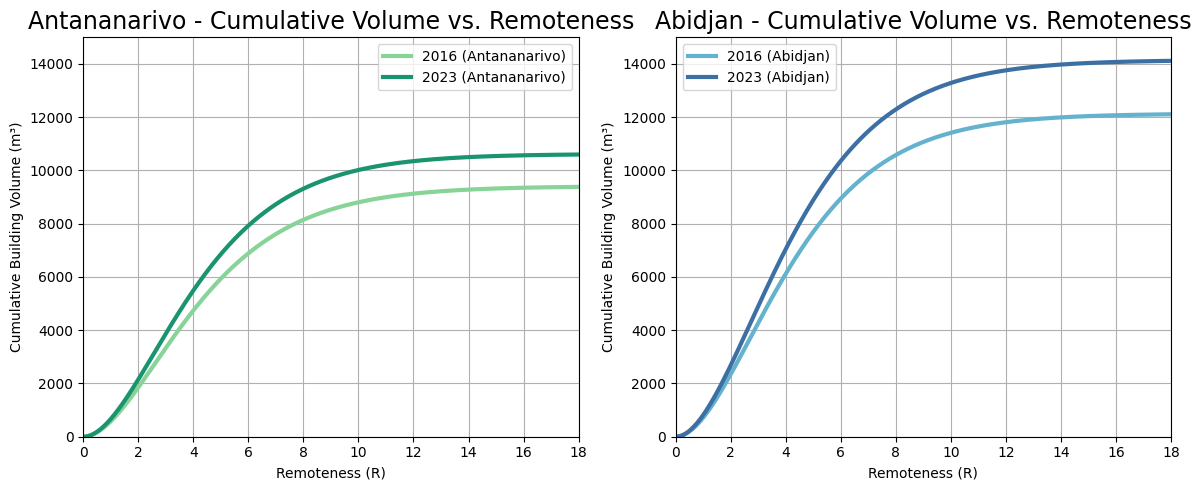

In [23]:
from scipy.integrate import quad
# ===== 图4：累计体积随 Remoteness 增长的曲线图 =====
fig_cum, axes_cum = plt.subplots(1, 2, figsize=(12, 5))

for i, (label1, label2) in enumerate(city_pairs):
    ax = axes_cum[i]
    for j, label in enumerate([label1, label2]):
        city = label.split()[0]
        year = label.split()[1]

        # 找到对应模型参数
        logit_row = next(r for r in logit_results if r['City'] == city and r['Year'] == year)
        exp_row = next(r for r in exp_results if r['City'] == city and r['Year'] == year)

        kappa = logit_row['kappa']
        delta = logit_row['delta']
        alpha = exp_row['alpha']
        beta = exp_row['beta']

        # 定义复合体积密度函数
        def volume_density(R):
            prob = 1 / (1 + np.exp(-(kappa + delta * R)))
            height = alpha * np.exp(-beta * R)
            return pixel_area * prob * height * 2 * np.pi * R

        # 构建 x 轴 remoteness 采样点
        R_vals = np.linspace(0, xlim_max, 500)
        cum_vals = np.zeros_like(R_vals)

        # 使用累积积分计算每个 R 的体积
        for idx, R in enumerate(R_vals):
            cum_vals[idx], _ = quad(volume_density, 0, R)

        ax.plot(R_vals, cum_vals, color=colors[j + i*2], linewidth=3, label=f"{year} ({city})")

    ax.set_title(f"{city} - Cumulative Volume vs. Remoteness", fontsize=17)
    ax.set_xlabel("Remoteness (R)")
    ax.set_ylabel("Cumulative Building Volume (m³)")
    ax.set_ylim(0, 15000)
    ax.set_xlim(0, 18)
    ax.legend()
    ax.grid(True)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(2))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(2000))

plt.tight_layout()
plt.savefig('visualizations/cumulative_volume_vs_remoteness.png')
plt.show()

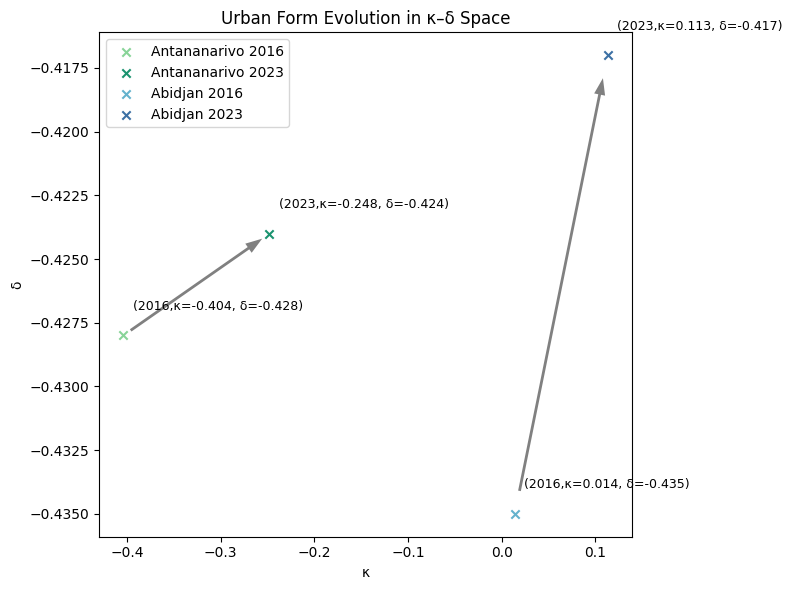

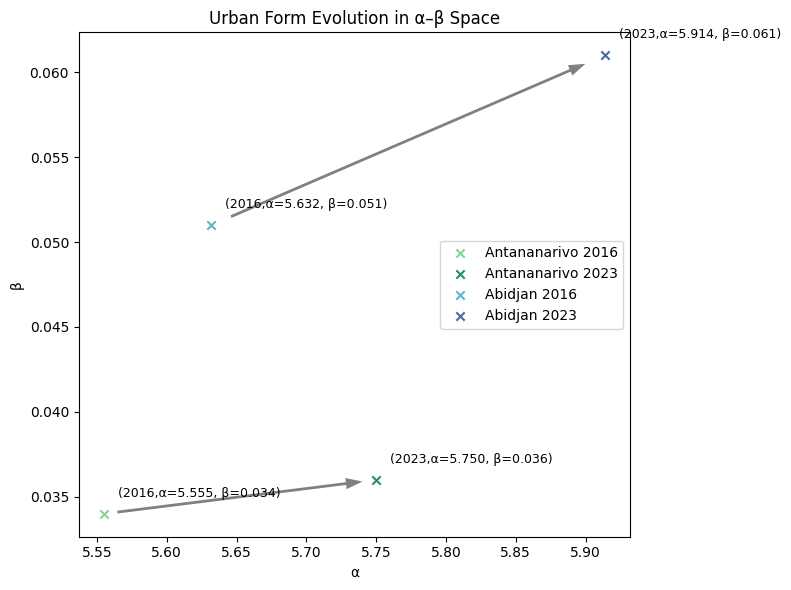

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Load data
df_area = pd.read_csv("area_remoteness_params.csv")
df_height = pd.read_csv("height_remoteness_params.csv")

# Extract parameters
k_all, d_all = df_area['kappa'], df_area['delta']
a_all, b_all = df_height['alpha'], df_height['beta']

# Define parameter dictionaries
area_params = {
    'Antananarivo': {'2016': (k_all[0], d_all[0]), '2023': (k_all[1], d_all[1])},
    'Abidjan': {'2016': (k_all[2], d_all[2]), '2023': (k_all[3], d_all[3])}
}

height_params = {
    'Antananarivo': {'2016': (a_all[0], b_all[0]), '2023': (a_all[1], b_all[1])},
    'Abidjan': {'2016': (a_all[2], b_all[2]), '2023': (a_all[3], b_all[3])}
}

# Corrected color dictionary
colors = {
    'Antananarivo': ('#88D498', '#1A936F'),
    'Abidjan': ('#64B2CD', '#3C70A4')
}

def plot_param_evolution(params, x_label, y_label, title, filename=None):
    fig, ax = plt.subplots(figsize=(8, 6))
    
    for city, years in params.items():
        x_start, y_start = years['2016']
        x_end, y_end = years['2023']
        
        # Arrow
        ax.annotate(
            '', xy=(x_end, y_end), xytext=(x_start, y_start),
            arrowprops=dict(
                facecolor="grey", edgecolor='none',
                shrink=0.05, width=2, headwidth=8
            )
        )
        
        # Points
        ax.scatter(x_start, y_start, color=colors[city][0], label=f"{city} 2016", marker='x')
        ax.scatter(x_end, y_end, color=colors[city][1], label=f"{city} 2023", marker='x')
        
        # Labels
        ax.text(x_start + 0.01, y_start + 0.001, f"(2016,{x_label}={x_start:.3f}, {y_label}={y_start:.3f})", fontsize=9)
        ax.text(x_end + 0.01, y_end + 0.001, f"(2023,{x_label}={x_end:.3f}, {y_label}={y_end:.3f})", fontsize=9)
    
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.legend()
    plt.tight_layout()

    if filename:
        import os
        plt.savefig(filename, dpi=300)

    plt.show()

# Plot both parameter spaces
plot_param_evolution(
    area_params, 'κ', 'δ', 'Urban Form Evolution in κ–δ Space',
    filename='visualizations/kd_space_evolution.png'
)

plot_param_evolution(
    height_params, 'α', 'β', 'Urban Form Evolution in α–β Space',
    filename='visualizations/ab_space_evolution.png'
)

In [21]:
import numpy as np

def probability_from_log_odds(log_odds):
    """
    Calculate the probability from a given log-odds.

    Parameters:
    log_odds (float or np.ndarray): The log-odds value(s) to convert to probability.

    Returns:
    float or np.ndarray: The probability of the given log-odds value(s).
    """
    # Ensure the input is a numpy array for element-wise operations
    log_odds = np.asarray(log_odds)

    # Calculate the probability
    probability = 1 / (1 + np.exp(-log_odds))

    return probability